In [1]:
# import all necessary things
%matplotlib nbagg

import qcodes as qc
import qcodes.instrument.parameter as parameter
import qcodes.instrument_drivers.AlazarTech.ATS9870 as ATSdriver
import qcodes.instrument_drivers.AlazarTech.ATS_acquisition_controllers as ats_contr

qc.halt_bg()
qc.set_mp_method('spawn')  # force Windows behavior on mac

# this makes a widget in the corner of the window to show and control
# subprocesses and any output they would print to the terminal
qc.show_subprocess_widget()

<IPython.core.display.Javascript object>

pyqtgraph plotting not supported, try "from qcodes.plots.pyqtgraph import QtPlot" to see the full error
No loop running


In [2]:
# Command to list all alazar boards connected to the system
ATSdriver.AlazarTech_ATS.find_boards()

[{'bits_per_sample': 8,
  'board_id': 1,
  'board_kind': 'ATS9870',
  'max_samples': 4294966272,
  'system_id': 1}]

In [3]:
# Create the ATS9870 instrument on the new server "alazar_server"
ats_inst = ATSdriver.AlazarTech_ATS9870(name='Alazar1', server_name="alazar_server")
# Print all information about this Alazar card
ats_inst.get_idn()

{'CPLD_version': '13.8',
 'SDK_version': '5.9.11',
 'asopc_type': '2435577968',
 'driver_version': '5.9.11',
 'firmware': None,
 'latest_cal_date': '29-05-13',
 'memory_size': '4294966272',
 'model': 'ATS9870',
 'pcie_link_speed': '0.25GB/s',
 'pcie_link_width': '4',
 'serial': '910323',
 'vendor': 'AlazarTech'}

In [4]:
# Instantiate an acquisition controller (In this case we are doing a simple DFT) on the same server ("alazar_server") and 
# provide the name of the name of the alazar card that this controller should control
acquisition_controller = ats_contr.DFT_AcquisitionController(name='acquisition_controller', 
                                                             demodulation_frequency=10e6, 
                                                             alazar_name='Alazar1', 
                                                             server_name="alazar_server")

In [5]:
# Configure all settings in the Alazar card
ats_inst.config(#clock_source='INTERNAL_CLOCK',
                sample_rate=100000000,
                #clock_edge='CLOCK_EDGE_RISING',
                #decimation=0,
                #coupling=['AC','AC'],
                channel_range=[2.,2.],
                #impedance=[50,50],
                #bwlimit=['DISABLED','DISABLED'],
                #trigger_operation='TRIG_ENGINE_OP_J',
                #trigger_engine1='TRIG_ENGINE_J',
                trigger_source1='EXTERNAL',
                #trigger_slope1='TRIG_SLOPE_POSITIVE',
                #trigger_level1=128,
                #trigger_engine2='TRIG_ENGINE_K',
                #trigger_source2='DISABLE',
                #trigger_slope2='TRIG_SLOPE_POSITIVE',
                #trigger_level2=128,
                #external_trigger_coupling='AC',
                #external_trigger_range='ETR_5V',
                #trigger_delay=0,
                #timeout_ticks=0
)

In [6]:
# This command is specific to this acquisition controller. The kwargs provided here are being forwarded to ats_inst.acquire
# This way, it becomes easy to change acquisition specific settings from the ipython notebook
acquisition_controller.set_acquisitionkwargs(#mode='NPT',
                 samples_per_record=1024,
                 records_per_buffer=70,
                 buffers_per_acquisition=1,
                 #channel_selection='AB',
                 #transfer_offset=0,
                 #external_startcapture='ENABLED',
                 #enable_record_headers='DISABLED',
                 #alloc_buffers='DISABLED',
                 #fifo_only_streaming='DISABLED',
                 #interleave_samples='DISABLED',
                 #get_processed_data='DISABLED',
                 allocated_buffers=64,
                 #buffer_timeout=1000
)

In [7]:
# Getting the value of the parameter 'acquisition' of the instrument 'acquisition_controller' performes the entire acquisition 
# protocol. This again depends on the specific implementation of the acquisition controller
acquisition_controller.acquisition()

0.024900543063357889

In [8]:
# make a snapshot of the 'ats_inst' instrument
ats_inst.snapshot()

{'__class__': 'qcodes.instrument_drivers.AlazarTech.ATS9870.AlazarTech_ATS9870',
 'functions': {},
 'name': 'Alazar1',
 'parameters': {'IDN': {'__class__': 'qcodes.instrument.parameter.StandardParameter',
   'instrument': 'qcodes.instrument_drivers.AlazarTech.ATS9870.AlazarTech_ATS9870',
   'instrument_name': 'Alazar1',
   'label': 'IDN',
   'name': 'IDN',
   'ts': '2016-08-16 14:21:37',
   'units': '',
   'value': {'CPLD_version': '13.8',
    'SDK_version': '5.9.11',
    'asopc_type': '2435577968',
    'driver_version': '5.9.11',
    'firmware': None,
    'latest_cal_date': '29-05-13',
    'memory_size': '4294966272',
    'model': 'ATS9870',
    'pcie_link_speed': '0.25GB/s',
    'pcie_link_width': '4',
    'serial': '910323',
    'vendor': 'AlazarTech'}},
  'alloc_buffers': {'__class__': 'qcodes.instrument_drivers.AlazarTech.ATS.AlazarParameter',
   'label': 'Alloc Buffers',
   'name': 'alloc_buffers',
   'ts': '2016-08-16 14:21:37',
   'units': '',
   'value': 'DISABLED'},
  'alloca

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = '2016-08-16/14-21-37_AlazarTest'
   <Type>   | <array_id>                         | <array.name> | <array.shape>
   Setpoint | dummy_set                          | dummy        | (50,)
   Measured | acquisition_controller_acquisition | acquisition  | (50,)
started at 2016-08-16 14:21:39


<IPython.core.display.Javascript object>


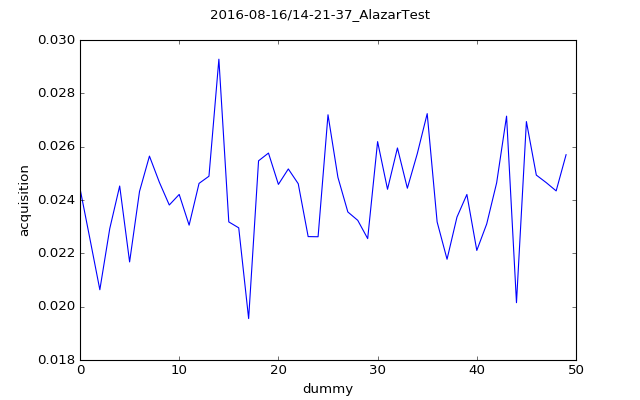

In [9]:
# Finally show that this instrument also works within a loop
dummy = parameter.ManualParameter(name="dummy")
data = qc.Loop(dummy[0:50:1]).each(acquisition_controller.acquisition).run(name='AlazarTest')
qc.MatPlot(data.acquisition_controller_acquisition)